<!--
If you are reading this, please recognize that this notebook is heavily catered to be PDF export friendly.
There will be large blocks of code in order to keep sections grouped together to minimize spacing, and a lot of markdown.
This will certainly not be a love letter to Jupyter Lab.
-->

In [1]:
import pandas as pd
import os
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import ngrams

import nbconvert
import plotly.io as pio
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px

from IPython.display import Markdown, SVG, display, Image, HTML

# Download the stopwords below through nltk once.
# nltk.download('stopwords')
# nltk.download('punkt')

# Defintion to churn out totals/percentages to avoid copy pasta.
def summarize_column(df, column_name):
    non_null_data = df[column_name].dropna()
    summary = non_null_data.value_counts()
    percentages = (non_null_data.value_counts(normalize=True) * 100).round(1)
    summary = pd.DataFrame({'Total': summary, 'Percentage': percentages})
    sample_size = non_null_data.shape[0]
    return summary, sample_size

<div style="text-align: center;">

<h1>Yarn Survey 2024</h1>

<h4>Presented by</h4>

<h2>Premier Needle Arts</h2>

</div>
<br>
<br>
<div style="page-break-after: always; text-align: center;">
    The 2024 Yarn Survey was put on by Knit Picks, Berroco, and Crochet.com <br> to get more contextual knowledge of knitters, crocheters, and general yarn enthusiasts.
</div>

In [2]:
all_responses = pd.read_csv('./CSV/all_processed.csv', encoding='utf-8')

In [3]:
# To export the notebook, uncomment the lines below.
# %%capture
# !jupyter nbconvert --to webpdf Yarn_survey.ipynb --output All_PDF_Export --output-dir ./PDF --no-input

In [4]:
# Question List for column index referencing. This saves a lot of time.
[(i, col) for i, col in enumerate(all_responses.columns.tolist())]

[(0, '#'),
 (1, 'First name'),
 (2, 'Email'),
 (3, 'Do you participate in any yarn crafts?'),
 (4, 'Do you crochet?'),
 (5, 'What is your current skill level in crocheting?'),
 (6, 'How often do you crochet?'),
 (7, 'Do you knit?'),
 (8, 'What is your current skill level in knitting?'),
 (9, 'How often do you knit?'),
 (10, 'Do you participate in yarn crafts besides crochet or knitting?'),
 (11, 'Which yarn craft do you participate in?'),
 (12, 'What is your current skill level in this yarn craft?'),
 (13, 'How often do you you participate in this yarn craft?'),
 (14, 'How do you most often purchase *yarn*?'),
 (15, 'Where do you most often purchase* yarn*?'),
 (16, 'How do you most often purchase yarn *tools & accessories*?'),
 (17, 'Where do you most often purchase *tools & accessories*?'),
 (18, 'How do you most often purchase *patterns*?'),
 (19, 'Where do you most often purchase *patterns*?'),
 (20, 'How have your yarn shopping habits changed over time?'),
 (21,
  'How many times 

## Demographic Summary

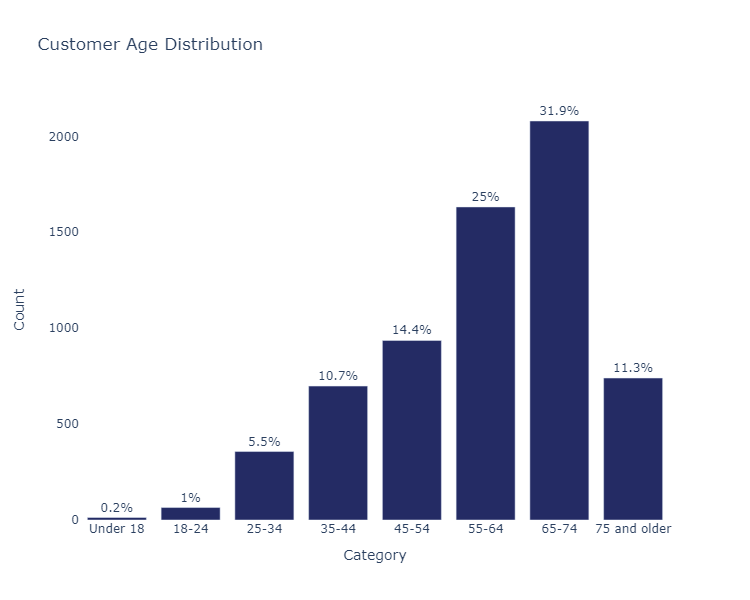

 - Out of **6521** respondants, the average respondant age is: **58** and the median age is: **59**.

- Of these respondants, they identify as:
    - "Woman" (98%)
    - "Non-Conforming / Non-Binary" (1%)
    - "Man" (1%)
    - "Transgender" (0%)


- The average household income is: **\$89,596** and the median household income is: **\$72,499** (From 4527 responses).
  - For ages **Under 18** the average household income is **\\$22,500**, the median household income is **\\$20,000** (From 3 responses.)
  - For ages **18-24** the average household income is **\\$61,250**, the median household income is **\\$42,500** (From 40 responses.)
  - For ages **25-34** the average household income is **\\$87,831**, the median household income is **\\$72,500** (From 287 responses.)
  - For ages **35-44** the average household income is **\\$102,103**, the median household income is **\\$90,000** (From 517 responses.)
  - For ages **45-54** the average household income is **\\$105,719**, the median household income is **\\$112,500** (From 594 responses.)
  - For ages **55-64** the average household income is **\\$97,537**, the median household income is **\\$90,000** (From 997 responses.)
  - For ages **65-74** the average household income is **\\$79,221**, the median household income is **\\$72,500** (From 1185 responses.)
  - For ages **75 and older** the average household income is **\\$74,103**, the median household income is **\\$57,500** (From 393 responses.)


In [5]:
#### Demographic Title Section ###
display(Markdown(f"## Demographic Summary"))
print("\n")

### Age Graph Section ###

question = all_responses.columns[76]
column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Age display order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# New line to convert 'Category' into an ordered categorical type with custom descending order
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Age Distribution',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Category',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=750,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/age.png")
display(Image(filename="./IMG/age.png"))

### Age Text Section ###

# Function to map age ranges to their average values
def map_age_to_average(value):
    if value == 'Under 18':
        return 18
    elif value == '18-24':
        return 21
    elif value == '25-34':
        return 29.5
    elif value == '35-44':
        return 39.5
    elif value == '45-54':
        return 49.5
    elif value == '55-64':
        return 59.5
    elif value == '65-74':
        return 69.5
    elif value == '75 and older':
        return 77
    else:
        return np.nan

# Apply the function to your column_data
age_data = column_data.map(map_age_to_average)
# Calculate the average age
average_age = age_data.mean().astype(int)
# Calculate the average age
median_age = age_data.median().astype(int)

display(Markdown(f" - Out of **{sample_size}** respondants, the average respondant age is: **{average_age}** and the median age is: **{median_age}**."))

### Identify Text Section ###

# Gender question.
question = all_responses.columns[77]

# Calculate percentage of each answer excluding nulls
summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output in Markdown
markdown_text = "- Of these respondants, they identify as:\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

### Income Section ###

# Income Question
question = all_responses.columns[81]
column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()

# Define the function to map income ranges to their midpoints
def map_income_to_midpoint(value):
    if value == 'Under $20,000':
        return 20000
    elif value == '$20,000 - $34,999':
        return (20000 + 34999) / 2
    elif value == '$35,000 - $49,999':
        return (35000 + 49999) / 2
    elif value == '$50,000 - $64,999':
        return (50000 + 64999) / 2
    elif value == '$65,000 - $79,999':
        return (65000 + 79999) / 2
    elif value == '$80,000 - $99,999':
        return (80000 + 99999) / 2
    elif value == '$100,000 - $124,999':
        return (100000 + 124999) / 2
    elif value == '$125,000 - $149,999':
        return (125000 + 149999) / 2
    elif value == '$150,000 - $174,999':
        return (150000 + 174999) / 2
    elif value == '$175,000 - $199,999':
        return (175000 + 199999) / 2
    elif value == 'Over $200,000':
        return 200000
    else:
        return np.nan

# Apply the function to the column data
income_data = column_data.map(map_income_to_midpoint)
# Calculate the average income
average_income = income_data.mean().astype(int)
# Calculate the median income
median_income = income_data.median().astype(int)
# Total count of responses
total_responses = income_data.dropna().count()
# Format the average and median income for readability with $ and commas
formatted_average_income = "\${:,.0f}".format(average_income)
formatted_median_income = "\${:,.0f}".format(median_income)

## Break down by age group. ##

age_question = all_responses.columns[76]

# Recreate filtered_responses DataFrame excluding 'Prefer not to answer'
filtered_responses = all_responses.loc[(all_responses[age_question] != 'Prefer not to answer') & 
                                        (all_responses[question] != 'Prefer not to answer')]

# Apply categorization and mapping for income midpoint again if necessary
filtered_responses['income_midpoint'] = filtered_responses[question].map(map_income_to_midpoint)
# Convert age_range to a categorical type with the specified order
filtered_responses['age_range'] = pd.Categorical(filtered_responses[all_responses.columns[76]], categories=categories, ordered=True)

# Now group by the 'age_range' with the specified order
statistics = filtered_responses.groupby('age_range', observed=True)['income_midpoint'].agg(['mean', 'median', 'count']).dropna()

# First part of the markdown about average and median income
markdown_part1 = f"- The average household income is: **{formatted_average_income}** and the median household income is: **{formatted_median_income}** (From {total_responses} responses)."

# Generating the second part with the breakdown by age group
markdown_part2 = ""
for age, row in statistics.iterrows():
    avg_income = "\${:,.0f}".format(row['mean'])
    median_income = "\${:,.0f}".format(row['median'])
    responses = row['count'].astype(int)
    markdown_part2 += f"  - For ages **{age}** the average household income is **\{avg_income}**, the median household income is **\{median_income}** (From {responses} responses.)\n"

# Combine the two parts into a single Markdown display, with the second part indented as a sub-list
combined_markdown = markdown_part1 + "\n" + markdown_part2
display(Markdown(combined_markdown))

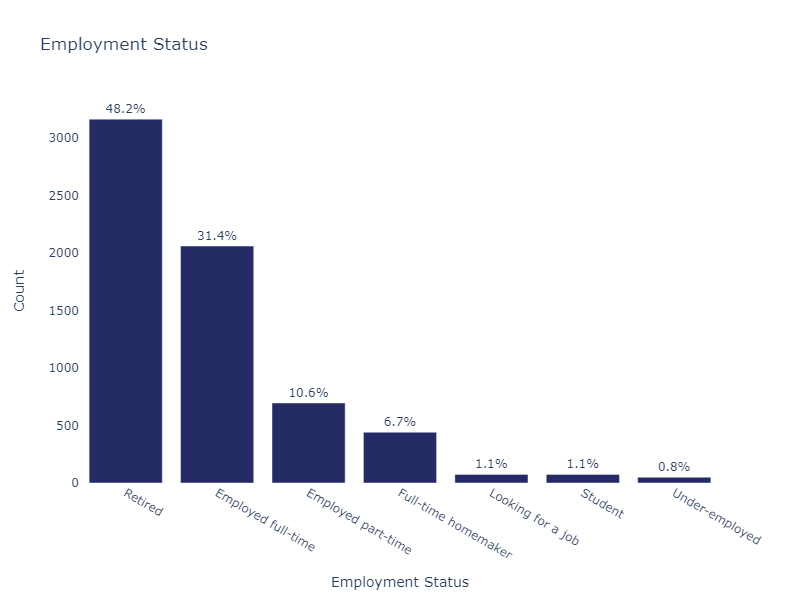

- Of the respondents, their employment statuses are as follows:  (From 6563 responses)
    - "Retired" (48%)
    - "Employed full-time" (31%)
    - "Employed part-time" (11%)
    - "Full-time homemaker" (7%)
    - "Looking for a job" (1%)
    - "Student" (1%)
    - "Under-employed" (1%)


In [6]:
### Employment ###
question = all_responses.columns[78]

column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Employment Status',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Employment Status',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/employment.png")
display(Image(filename="./IMG/employment.png"))

summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, their employment statuses are as follows:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

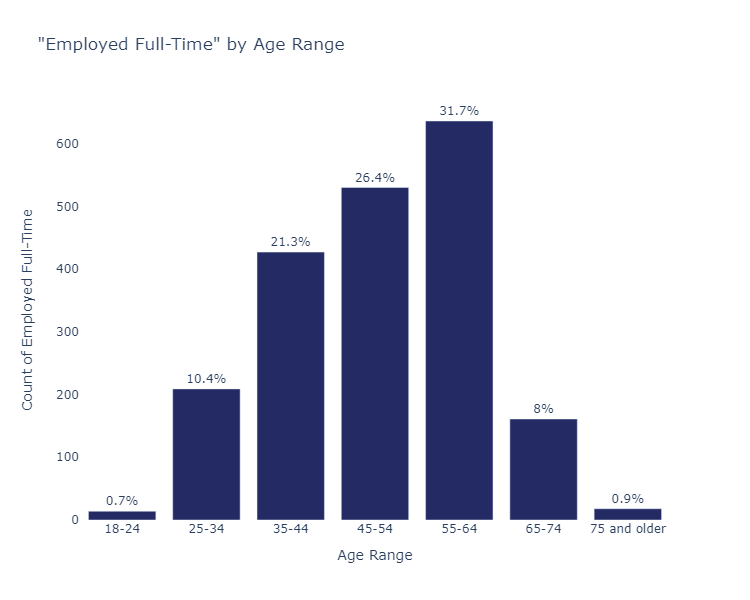

- Of those who responded 'Employed Full-Time': (From 2061 responses.)
    - "55-64" (31.7%)
    - "45-54" (26.4%)
    - "35-44" (21.3%)
    - "25-34" (10.4%)
    - "65-74" (8.0%)
    - "75 and older" (0.9%)
    - "18-24" (0.7%)


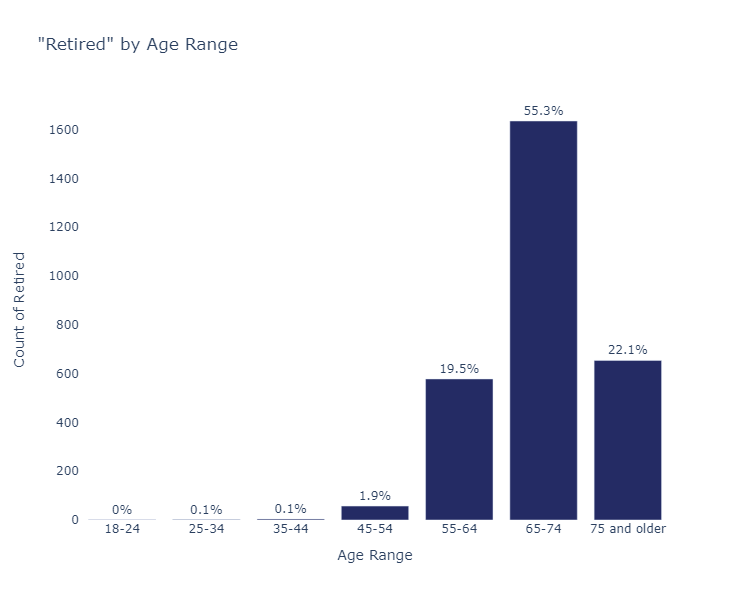

- Of those who responded 'Retired': (From 3165 responses.)
    - "65-74" (55.3%)
    - "75 and older" (22.1%)
    - "55-64" (19.5%)
    - "45-54" (1.9%)
    - "25-34" (0.1%)
    - "35-44" (0.1%)
    - "18-24" (0.0%)


In [11]:
# Assuming all_responses is your DataFrame
age_column = all_responses.columns[76]
employment_status_column = all_responses.columns[78]

# Filter for 'Employed full-time'
employed_full_time = all_responses[all_responses[employment_status_column] == 'Employed full-time']
sample_size = employed_full_time.shape[0]

# Filter based on age range
age_data = employed_full_time[age_column].dropna()

# Calculate counts and percentages
value_counts = age_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = age_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Define the age categories in ascending order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Convert 'Category' into an ordered categorical type
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='"Employed Full-Time" by Age Range',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Range',
    yaxis_title='Count of Employed Full-Time',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100)
)

# Save and display the figure
fig.write_image("./IMG/employed_full_time_by_age.png")
display(Image(filename="./IMG/employed_full_time_by_age.png"))


# Sort summary_df by 'Percentage' in descending order for display
summary_df_sorted = summary_df.sort_values('Percentage', ascending=False).dropna()

markdown_text = f"- Of those who responded 'Employed Full-Time': (From {sample_size} responses.)\n"
for row in summary_df_sorted.itertuples():
    age_group = row.Category
    percentage = row.Percentage
    # Ensure each line is indented under the introductory sentence
    markdown_text += f"    - \"{age_group}\" ({percentage}%)\n"

display(Markdown(markdown_text))

# Filter for 'Retired'
retired = all_responses[all_responses[employment_status_column] == 'Retired']
sample_size = retired.shape[0]

# Filter based on age range
age_data = retired[age_column].dropna()

# Calculate counts and percentages
value_counts = age_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = age_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Define the age categories in ascending order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Convert 'Category' into an ordered categorical type
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='"Retired" by Age Range',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Range',
    yaxis_title='Count of Retired',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100)
)

# Save and display the figure
fig.write_image("./IMG/retired_by_age.png")
display(Image(filename="./IMG/retired_by_age.png"))


# Sort summary_df by 'Percentage' in descending order for display
summary_df_sorted = summary_df.sort_values('Percentage', ascending=False).dropna()

markdown_text = f"- Of those who responded 'Retired': (From {sample_size} responses.)\n"
for row in summary_df_sorted.itertuples():
    age_group = row.Category
    percentage = row.Percentage
    # Ensure each line is indented under the introductory sentence
    markdown_text += f"    - \"{age_group}\" ({percentage}%)\n"

display(Markdown(markdown_text))


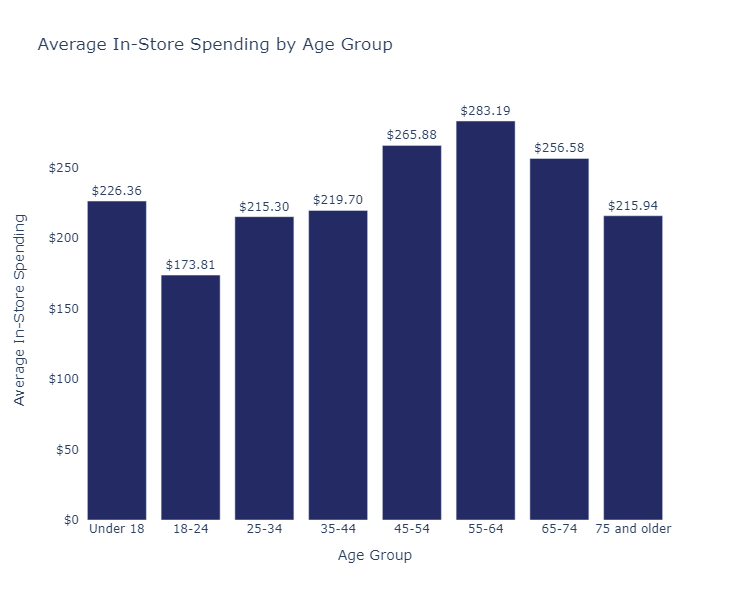

- Respondents reported making **4.7** purchases in-store per year on average, spending an average **\$53.28** per visit. On average spending **\$250.41** a year. (From 6673 responses.)
     - For the group 'Under 18', respondents reported making **6.0** purchases in-store per year on average, spending an average **\$37.73** per visit. On average spending **\$226.36** a year.
     - For the group '18-24', respondents reported making **4.9** purchases in-store per year on average, spending an average **\$35.46** per visit. On average spending **\$173.81** a year.
     - For the group '25-34', respondents reported making **4.6** purchases in-store per year on average, spending an average **\$46.88** per visit. On average spending **\$215.30** a year.
     - For the group '35-44', respondents reported making **4.4** purchases in-store per year on average, spending an average **\$50.26** per visit. On average spending **\$219.70** a year.
     - For the group '45-54', respondents reported making **5.1** purchases in-store per year on average, spending an average **\$52.54** per visit. On average spending **\$265.88** a year.
     - For the group '55-64', respondents reported making **5.0** purchases in-store per year on average, spending an average **\$57.01** per visit. On average spending **\$283.19** a year.
     - For the group '65-74', respondents reported making **4.7** purchases in-store per year on average, spending an average **\$54.74** per visit. On average spending **\$256.58** a year.
     - For the group '75 and older', respondents reported making **4.3** purchases in-store per year on average, spending an average **\$50.13** per visit. On average spending **\$215.94** a year.

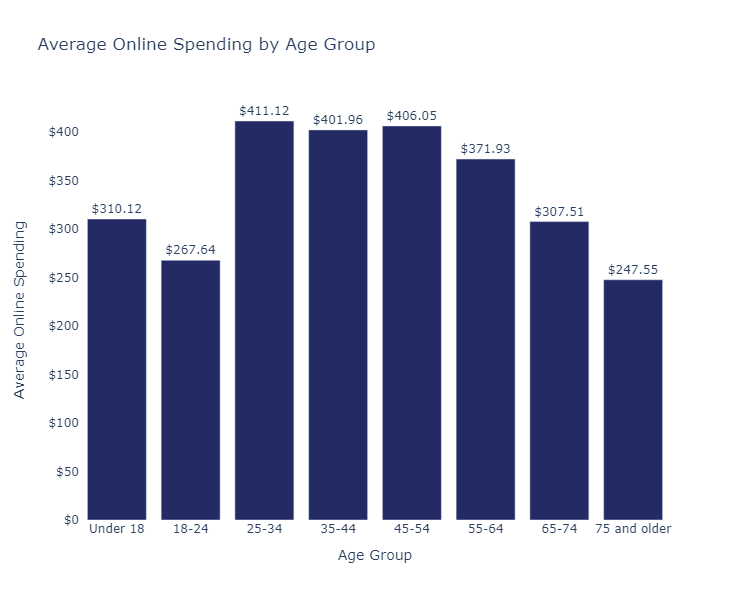

- Respondents reported making **5.0** purchases online per year on average, spending an average **\$67.33** per visit. On average spending **\$338.77** a year. (From 6799 responses.)
     - For the group 'Under 18', respondents reported making **5.4** purchases in-store per year on average, spending an average **\$57.82** per visit. On average spending **\$310.12** a year.
     - For the group '18-24', respondents reported making **5.0** purchases in-store per year on average, spending an average **\$53.70** per visit. On average spending **\$267.64** a year.
     - For the group '25-34', respondents reported making **5.4** purchases in-store per year on average, spending an average **\$76.23** per visit. On average spending **\$411.12** a year.
     - For the group '35-44', respondents reported making **5.4** purchases in-store per year on average, spending an average **\$74.90** per visit. On average spending **\$401.96** a year.
     - For the group '45-54', respondents reported making **5.5** purchases in-store per year on average, spending an average **\$73.95** per visit. On average spending **\$406.05** a year.
     - For the group '55-64', respondents reported making **5.3** purchases in-store per year on average, spending an average **\$70.55** per visit. On average spending **\$371.93** a year.
     - For the group '65-74', respondents reported making **4.8** purchases in-store per year on average, spending an average **\$63.54** per visit. On average spending **\$307.51** a year.
     - For the group '75 and older', respondents reported making **4.3** purchases in-store per year on average, spending an average **\$57.42** per visit. On average spending **\$247.55** a year.

In [8]:
# Function to number to string
def assign_count(value):
    if value == '10+':
        return 10
    else:
        return value

# Function to assign middle value
def assign_middle_price(value):
    if value == '$200 +':
        return 200
    elif value == '$0':
        return 0
    else:
        low, high = value.replace('$', '').split(' - ')
        return (int(low) + int(high)) // 2

# Combining all the columns into one dataframe
share_of_wallet = pd.concat([all_responses[[all_responses.columns[21], all_responses.columns[22], all_responses.columns[23], all_responses.columns[24], all_responses.columns[76]]]], axis=1)

# Clean up entries of "10+"
share_of_wallet.iloc[:, [0, 2]] = share_of_wallet.iloc[:, [0, 2]].apply(lambda x: x.apply(lambda y: assign_count(y) if pd.notnull(y) else y))

# Clean up entries of "200+" and remove $.
share_of_wallet.iloc[:, [1, 3]] = share_of_wallet.iloc[:, [1, 3]].apply(lambda x: x.apply(lambda y: assign_middle_price(y) if pd.notnull(y) else y))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
filtered_df = share_of_wallet[share_of_wallet.iloc[:, 4] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
filtered_df[filtered_df.columns[4]] = pd.Categorical(filtered_df[filtered_df.columns[4]], categories=ages, ordered=True)

# Convert 'Age Group' column to a categorical type with specified order
filtered_df['Age Group'] = filtered_df[filtered_df.columns[4]]
filtered_df['Age Group'] = pd.Categorical(filtered_df['Age Group'], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
mean_purchases_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
mean_spending_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

# Multiply the means to get 'Total In-Store' for each group
total_instore_by_group = mean_purchases_by_group * mean_spending_by_group

# Reset index to use in Plotly Express and rename columns for clarity
total_instore_by_group = total_instore_by_group.reset_index().rename(columns={0: 'Total In-Store'})

# Create the bar graph
fig = px.bar(total_instore_by_group, x='Age Group', y='Total In-Store', title='Average In-Store Spending by Age Group',
             text=[f"${v:,.2f}" for v in total_instore_by_group['Total In-Store']], color_discrete_sequence=['#242B64'])

# Customization for displaying formatted values above bars
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Average In-Store Spending',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100),
    yaxis_tickprefix="$",
    yaxis_tickformat=","
)

# Save and display the figure
fig.write_image("./IMG/instore_spend_by_age.png")
display(Image(filename="./IMG/instore_spend_by_age.png"))

# Markdown variables
sample_size_instore = share_of_wallet.iloc[:, 0].dropna().count()
avg_purchases_instore = share_of_wallet.iloc[:, 0].astype(float).mean()
avg_spending_instore = share_of_wallet.iloc[:, 1].astype(float).mean()
total_instore = avg_purchases_instore * avg_spending_instore

markdown_part1 = f"- Respondents reported making **{avg_purchases_instore:.1f}** purchases in-store per year on average, spending an average **\${avg_spending_instore:.2f}** per visit. On average spending **\${total_instore:.2f}** a year. (From {sample_size_instore} responses.)"

# Group by the demographic data in column [76] and calculate metrics
for group, frame in filtered_df.groupby(filtered_df.columns[4], observed=True):
    #group_sample_size_instore = frame.iloc[:, 0].dropna().count()
    group_avg_purchases_instore = frame.iloc[:, 0].astype(float).mean()
    group_avg_spending_instore = frame.iloc[:, 1].astype(float).mean()
    group_total_instore = group_avg_purchases_instore * group_avg_spending_instore
    # Append the group metrics to the markdown text
    markdown_part1 += f"\n     - For the group '{group}', respondents reported making **{group_avg_purchases_instore:.1f}** purchases in-store per year on average, spending an average **\${group_avg_spending_instore:.2f}** per visit. On average spending **\${group_total_instore:.2f}** a year."

# Display the markdown text
display(Markdown(markdown_part1))

# Calculate the mean of the two columns by group
mean_purchases_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[2]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
mean_spending_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[3]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

# Multiply the means to get 'Total In-Store' for each group
total_online_by_group = mean_purchases_by_group * mean_spending_by_group

# Reset index to use in Plotly Express and rename columns for clarity
total_online_by_group = total_online_by_group.reset_index().rename(columns={0: 'Total Online'})

# Create the bar graph
fig = px.bar(total_online_by_group, x='Age Group', y='Total Online', title='Average Online Spending by Age Group',
             text=[f"${v:,.2f}" for v in total_online_by_group['Total Online']], color_discrete_sequence=['#242B64'])

# Customization for displaying formatted values above bars
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Average Online Spending',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100),
    yaxis_tickprefix="$",
    yaxis_tickformat=","
)

# Save and display the figure
fig.write_image("./IMG/online_spend_by_age.png")
display(Image(filename="./IMG/online_spend_by_age.png"))

# Markdown variables
sample_size_online = share_of_wallet.iloc[:, 2].dropna().count()
avg_purchases_online = share_of_wallet.iloc[:, 2].astype(float).mean()
avg_spending_online = share_of_wallet.iloc[:, 3].astype(float).mean()
total_online = avg_purchases_online * avg_spending_online

markdown_part2 = f"- Respondents reported making **{avg_purchases_online:.1f}** purchases online per year on average, spending an average **\${avg_spending_online:.2f}** per visit. On average spending **\${total_online:.2f}** a year. (From {sample_size_online} responses.)"

# Group by the demographic data in column [76] and calculate metrics
for group, frame in filtered_df.groupby(filtered_df.columns[4], observed=True):
    #group_sample_size_online = frame.iloc[:, 2].dropna().count()
    group_avg_purchases_online = frame.iloc[:, 2].astype(float).mean()
    group_avg_spending_online = frame.iloc[:, 3].astype(float).mean()
    group_total_online = group_avg_purchases_online * group_avg_spending_online
    # Append the group metrics to the markdown text
    markdown_part2 += f"\n     - For the group '{group}', respondents reported making **{group_avg_purchases_online:.1f}** purchases in-store per year on average, spending an average **\${group_avg_spending_online:.2f}** per visit. On average spending **\${group_total_online:.2f}** a year."

# Display the markdown text
display(Markdown(markdown_part2))

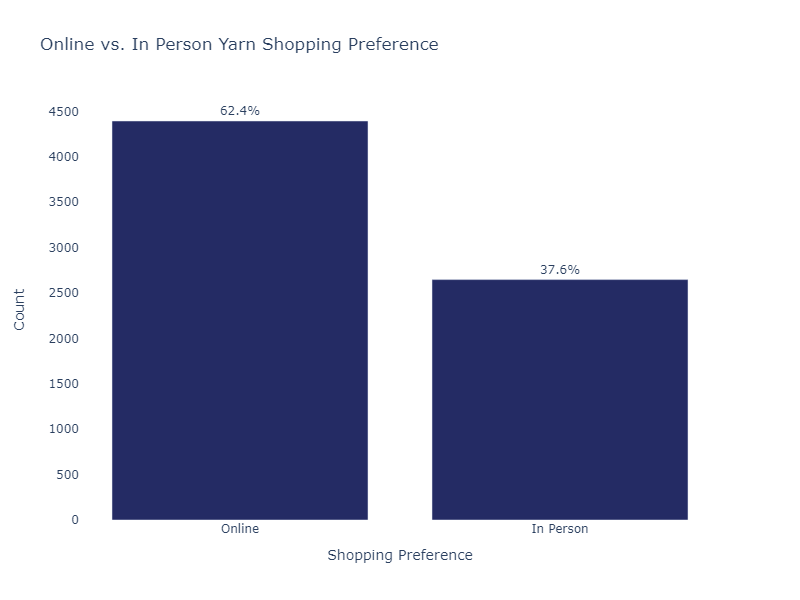

- Of the respondants **58.2%** preferred online shopping for yarn, while **35.04%** preferred shopping in person for yarn. (From 7043 responses.)
     - For the group 'Under 18', **30.8%** preferred shopping online, **69.2%** preferred shopping in person.
     - For the group '18-24', **67.7%** preferred shopping online, **32.3%** preferred shopping in person.
     - For the group '25-34', **72.5%** preferred shopping online, **26.1%** preferred shopping in person.
     - For the group '35-44', **71.5%** preferred shopping online, **27.2%** preferred shopping in person.
     - For the group '45-54', **65.5%** preferred shopping online, **31.3%** preferred shopping in person.
     - For the group '55-64', **60.1%** preferred shopping online, **37.4%** preferred shopping in person.
     - For the group '65-74', **57.9%** preferred shopping online, **39.8%** preferred shopping in person.
     - For the group '75 and older', **53.1%** preferred shopping online, **43.8%** preferred shopping in person.

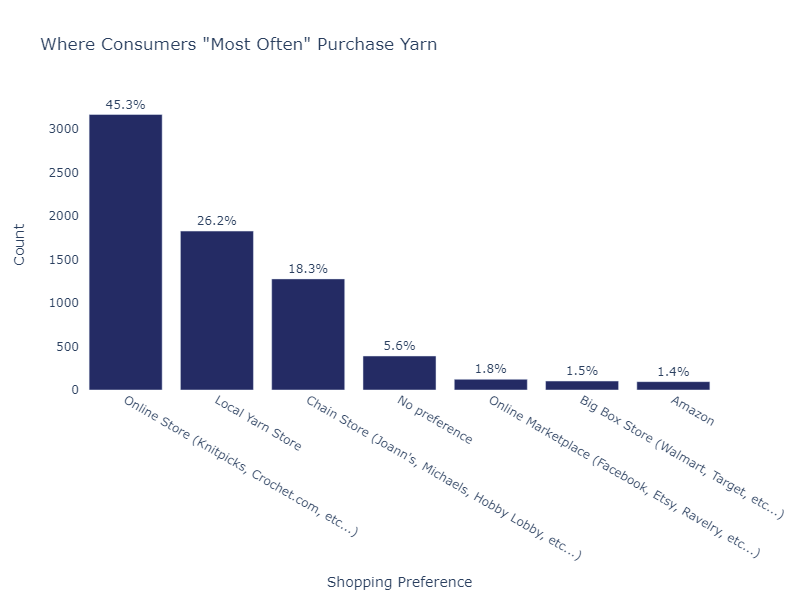

In [29]:
question = all_responses.columns[14]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In Person Yarn Shopping Preference',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/yarn_shopping.png")
display(Image(filename="./IMG/yarn_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[14], all_responses.columns[76]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondants **{online_percent:.1f}%** preferred online shopping for yarn, while **{inperson_percent:.2f}%** preferred shopping in person for yarn. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[15]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Yarn',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/yarn_shopping_location.png")
display(Image(filename="./IMG/yarn_shopping_location.png"))

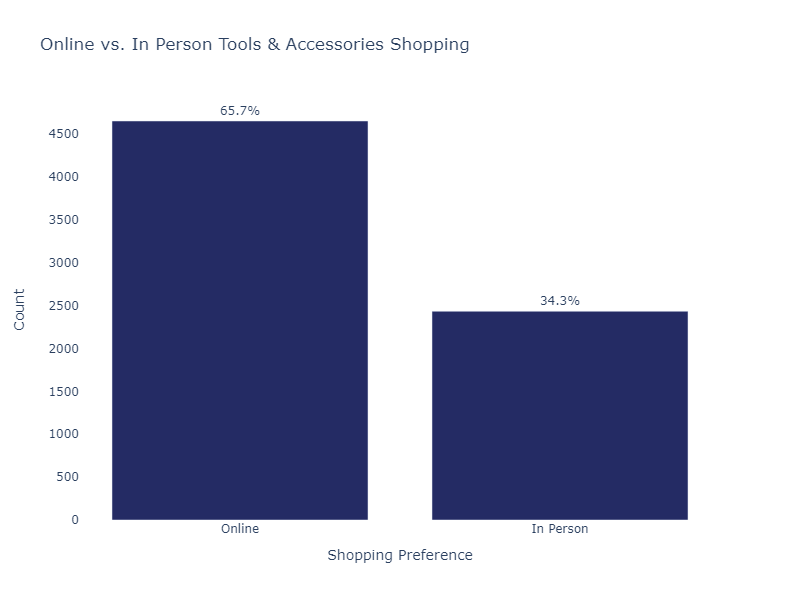

- Of the respondants **61.6%** preferred online shopping for tools & accessories, while **32.22%** preferred shopping in person for tools & accessories. (From 7090 responses.)
     - For the group 'Under 18', **53.8%** preferred shopping online, **46.2%** preferred shopping in person.
     - For the group '18-24', **69.2%** preferred shopping online, **30.8%** preferred shopping in person.
     - For the group '25-34', **73.1%** preferred shopping online, **25.8%** preferred shopping in person.
     - For the group '35-44', **77.8%** preferred shopping online, **21.1%** preferred shopping in person.
     - For the group '45-54', **71.2%** preferred shopping online, **26.7%** preferred shopping in person.
     - For the group '55-64', **64.1%** preferred shopping online, **34.2%** preferred shopping in person.
     - For the group '65-74', **61.2%** preferred shopping online, **37.1%** preferred shopping in person.
     - For the group '75 and older', **54.3%** preferred shopping online, **43.2%** preferred shopping in person.

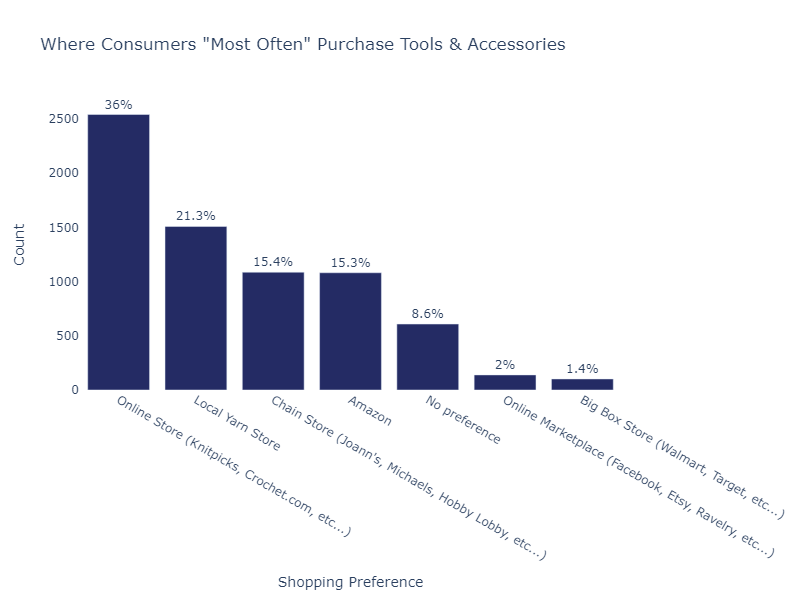

In [33]:
question = all_responses.columns[16]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In Person Tools & Accessories Shopping',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/tool_shopping.png")
display(Image(filename="./IMG/tool_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[16], all_responses.columns[76]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondants **{online_percent:.1f}%** preferred online shopping for tools & accessories, while **{inperson_percent:.2f}%** preferred shopping in person for tools & accessories. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[17]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Tools & Accessories',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/tool_shopping_location.png")
display(Image(filename="./IMG/tool_shopping_location.png"))

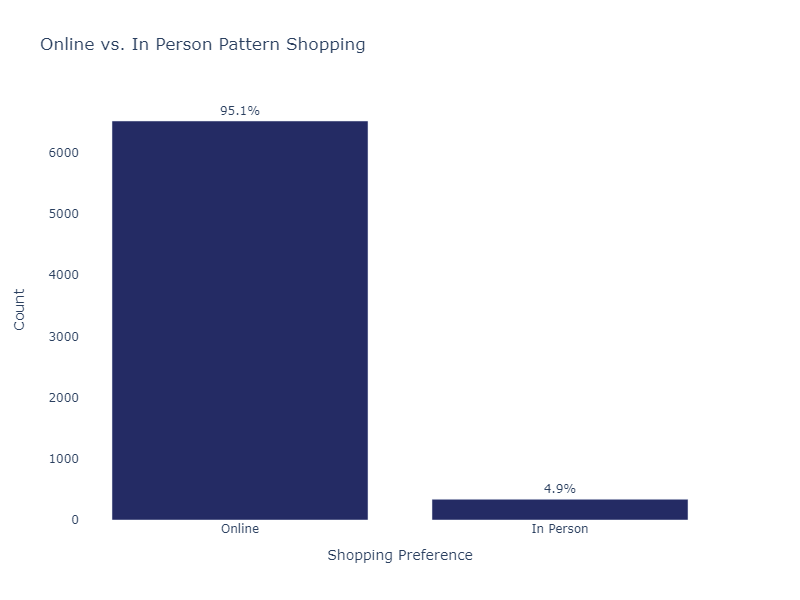

- Of the respondants **58.2%** preferred online shopping for patterns, while **35.04%** preferred shopping in person for patterns. (From 6856 responses.)
     - For the group 'Under 18', **30.8%** preferred shopping online, **69.2%** preferred shopping in person.
     - For the group '18-24', **67.7%** preferred shopping online, **32.3%** preferred shopping in person.
     - For the group '25-34', **72.5%** preferred shopping online, **26.1%** preferred shopping in person.
     - For the group '35-44', **71.5%** preferred shopping online, **27.2%** preferred shopping in person.
     - For the group '45-54', **65.5%** preferred shopping online, **31.3%** preferred shopping in person.
     - For the group '55-64', **60.1%** preferred shopping online, **37.4%** preferred shopping in person.
     - For the group '65-74', **57.9%** preferred shopping online, **39.8%** preferred shopping in person.
     - For the group '75 and older', **53.1%** preferred shopping online, **43.8%** preferred shopping in person.

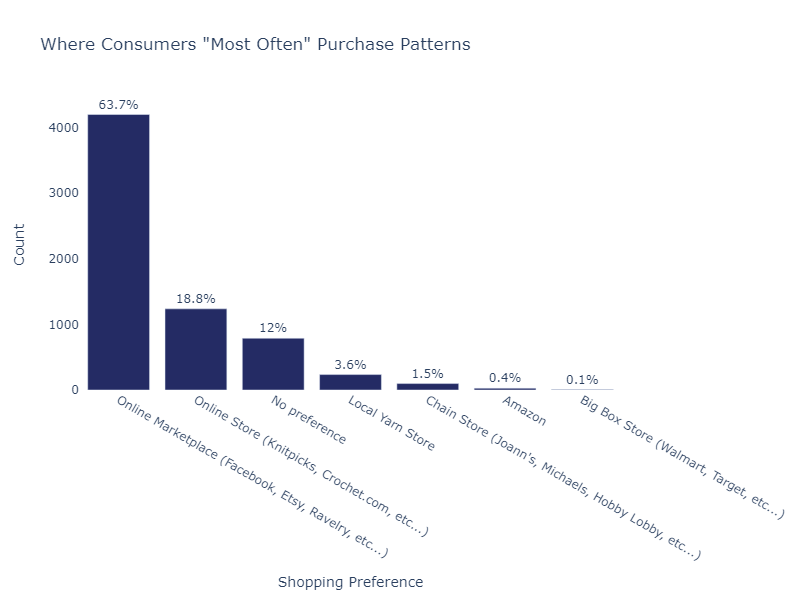

In [60]:
question = all_responses.columns[18]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In Person Pattern Shopping',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/pattern_shopping.png")
display(Image(filename="./IMG/pattern_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[18], all_responses.columns[76]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondants **{online_percent:.1f}%** preferred online shopping for patterns, while **{inperson_percent:.2f}%** preferred shopping in person for patterns. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[19]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Patterns',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/pattern_shopping_location.png")
display(Image(filename="./IMG/pattern_shopping_location.png"))

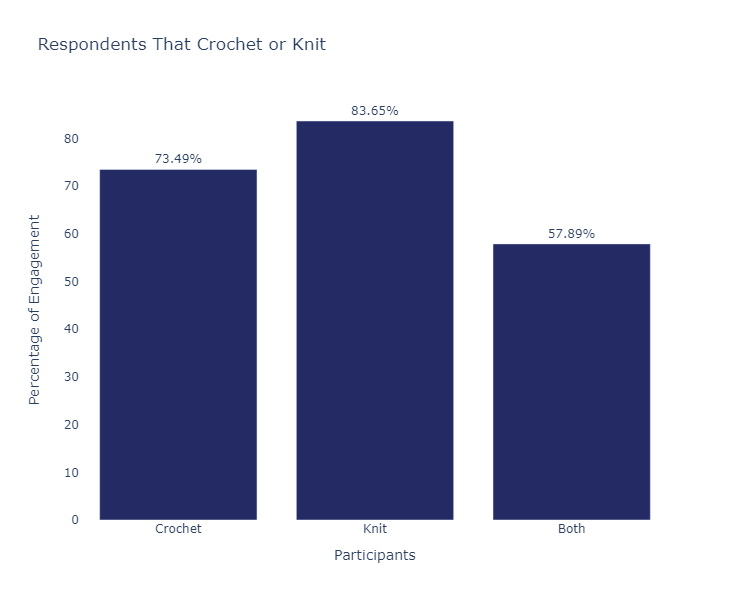

- Of the respondants, **73.5%** responded 'Yes' to crocheting, **83.65%** responded 'Yes' to knitting, while **57.89%** of respondants engage in both. (From 7558 responses.)
     - For the group 'Under 18', **100.0%** responded 'Yes' to crocheting, **61.5%** responded 'Yes' to knitting, and **61.5%** to both.
     - For the group '18-24', **90.8%** responded 'Yes' to crocheting, **67.7%** responded 'Yes' to knitting, and **58.5%** to both.
     - For the group '25-34', **82.6%** responded 'Yes' to crocheting, **73.4%** responded 'Yes' to knitting, and **56.3%** to both.
     - For the group '35-44', **79.1%** responded 'Yes' to crocheting, **78.9%** responded 'Yes' to knitting, and **58.0%** to both.
     - For the group '45-54', **78.5%** responded 'Yes' to crocheting, **78.6%** responded 'Yes' to knitting, and **57.2%** to both.
     - For the group '55-64', **77.5%** responded 'Yes' to crocheting, **81.6%** responded 'Yes' to knitting, and **59.0%** to both.
     - For the group '65-74', **69.7%** responded 'Yes' to crocheting, **89.9%** responded 'Yes' to knitting, and **59.7%** to both.
     - For the group '75 and older', **62.3%** responded 'Yes' to crocheting, **94.2%** responded 'Yes' to knitting, and **56.6%** to both.

In [36]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[4], all_responses.columns[7], all_responses.columns[76]]]], axis=1)

percent_yes = crafting_types[['Do you crochet?', 'Do you knit?']].apply(lambda x: (x == 'Yes').mean()) * 100
both_yes_percent = crafting_types[(crafting_types['Do you crochet?'] == 'Yes') & (crafting_types['Do you knit?'] == 'Yes')].shape[0] / crafting_types.shape[0] * 100
 
data = {'Crafting Type': ['Crochet', 'Knit'], 'Percentage': percent_yes.values}

# Update the data dictionary to include the new category
data['Crafting Type'].append('Both')
data['Percentage'] = np.append(data['Percentage'], both_yes_percent)

df = pd.DataFrame(data)

fig = px.bar(
    df,
    x='Crafting Type',
    y='Percentage',
    text='Percentage',
    title='Respondents That Crochet or Knit',
    color_discrete_sequence=['#242B64']
)

# Adding text on bars for the percentage value
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Participants',
    yaxis_title='Percentage of Engagement',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100)
)

# Save and display the figure
fig.write_image("./IMG/crafting_participation.png")
display(Image(filename="./IMG/crafting_participation.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Variables
# Overall percentage of respondents who answered 'Yes' to crocheting
crochet_yes_percent = (crafting_types['Do you crochet?'] == 'Yes').mean() * 100
# Overall percentage of respondents who answered 'Yes' to knitting
knit_yes_percent = (crafting_types['Do you knit?'] == 'Yes').mean() * 100
# Overall percentage of respondents who answered 'Yes' to both crocheting and knitting
both_yes_percent = ((crafting_types['Do you crochet?'] == 'Yes') & (crafting_types['Do you knit?'] == 'Yes')).mean() * 100
# Total sample size
sample_size = crafting_types.shape[0]

# Initialize the markdown string
markdown_summary = f"- Of the respondants, **{crochet_yes_percent:.1f}%** responded 'Yes' to crocheting, **{knit_yes_percent:.2f}%** responded 'Yes' to knitting, while **{both_yes_percent:.2f}%** of respondants engage in both. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = crafting_types[crafting_types['What is your current age?  '] == age]
    
    # Calculate the percentages and sample size for the current age group
    crochet_yes_percent = (age_group_df['Do you crochet?'] == 'Yes').mean() * 100
    knit_yes_percent = (age_group_df['Do you knit?'] == 'Yes').mean() * 100
    both_yes_percent = ((age_group_df['Do you crochet?'] == 'Yes') & (age_group_df['Do you knit?'] == 'Yes')).mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', **{crochet_yes_percent:.1f}%** responded 'Yes' to crocheting, **{knit_yes_percent:.1f}%** responded 'Yes' to knitting, and **{both_yes_percent:.1f}%** to both."

# Display the markdown summary
# Display the markdown text
display(Markdown(markdown_summary))

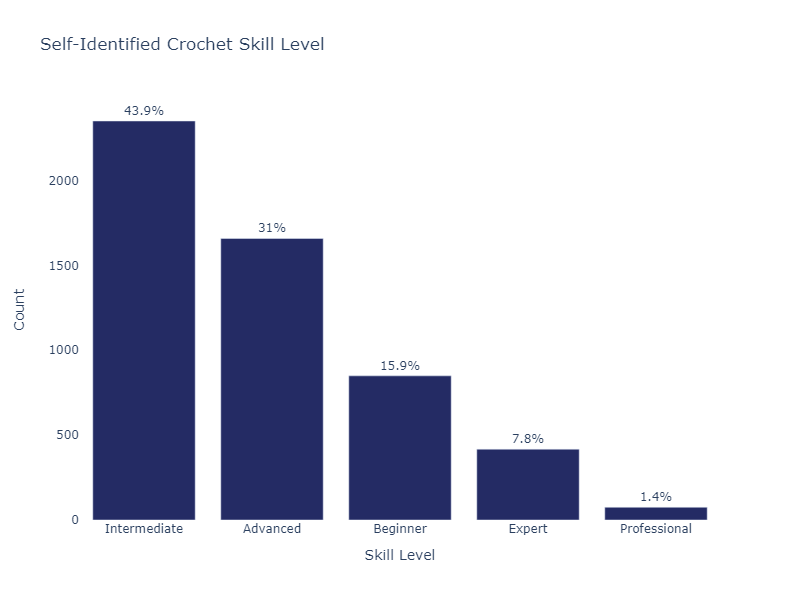

- Of the respondants who crochet, they rate their skill level as the following: (From 5554 responses.)
    - **43.93%** of respondents answered 'Intermediate'.
    - **31.00%** of respondents answered 'Advanced'.
    - **15.87%** of respondents answered 'Beginner'.
    - **7.80%** of respondents answered 'Expert'.
    - **1.40%** of respondents answered 'Professional'.


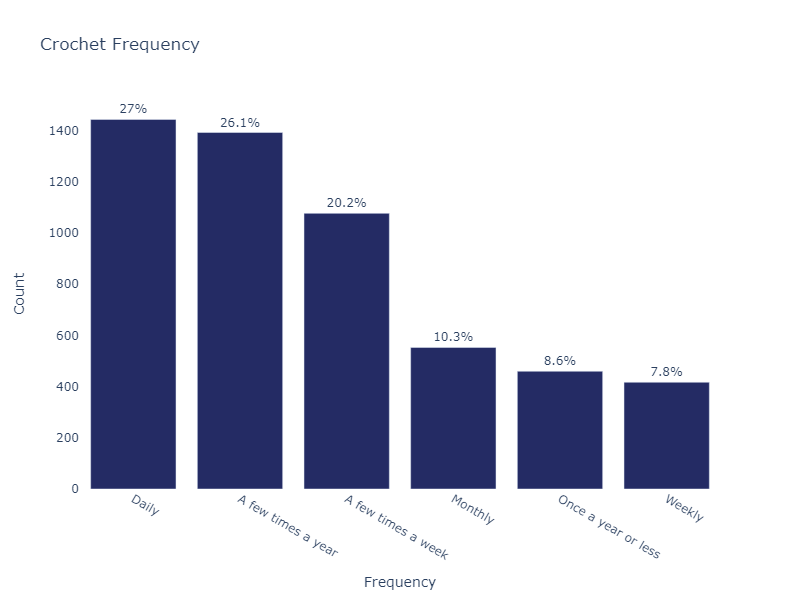

- Of the respondants who crochet, the frequency they do so is: (From 5554 responses.)
    - **27.02%** of respondents answered 'Daily'.
    - **26.07%** of respondents answered 'A few times a year'.
    - **20.15%** of respondents answered 'A few times a week'.
    - **10.35%** of respondents answered 'Monthly'.
    - **8.61%** of respondents answered 'Once a year or less'.
    - **7.80%** of respondents answered 'Weekly'.


In [57]:
# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 4] == 'Yes']
column_data = filtered_rows[[all_responses.columns[5], all_responses.columns[6], all_responses.columns[76]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Self-Identified Crochet Skill Level',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Skill Level',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/crochet_skill.png")
display(Image(filename="./IMG/crochet_skill.png"))


# What is your current skill level in crocheting?
sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[0]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondants who crochet, they rate their skill level as the following: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - **{percentage:.2f}%** of respondents answered '{answer}'.\n"
    
display(Markdown(markdown_summary))

# How often do you crochet?

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 1].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 1].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Crochet Frequency',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/crochet_frequency.png")
display(Image(filename="./IMG/crochet_frequency.png"))

sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[1]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondants who crochet, the frequency they do so is: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - **{percentage:.2f}%** of respondents answered '{answer}'.\n"
    
display(Markdown(markdown_summary))



In [58]:
# Focus on projects started and completed by crocheter.
# Then do age ranges.

# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 4] == 'Yes']
column_data = filtered_rows[[all_responses.columns[5], all_responses.columns[6], all_responses.columns[76]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Self-Identified Crochet Skill Level',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Skill Level',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/crochet_skill.png")
display(Image(filename="./IMG/crochet_skill.png"))



- Of the respondants, **62.3%** responded 'Yes' to crocheting, **94.19%** responded 'Yes' to knitting, while **56.62%** of respondants engage in both. (From 5554 responses.)
     - For the group 'Under 18', **100.0%** responded 'Yes' to crocheting, **61.5%** responded 'Yes' to knitting, and **61.5%** to both.
     - For the group '18-24', **90.8%** responded 'Yes' to crocheting, **67.7%** responded 'Yes' to knitting, and **58.5%** to both.
     - For the group '25-34', **82.6%** responded 'Yes' to crocheting, **73.4%** responded 'Yes' to knitting, and **56.3%** to both.
     - For the group '35-44', **79.1%** responded 'Yes' to crocheting, **78.9%** responded 'Yes' to knitting, and **58.0%** to both.
     - For the group '45-54', **78.5%** responded 'Yes' to crocheting, **78.6%** responded 'Yes' to knitting, and **57.2%** to both.
     - For the group '55-64', **77.5%** responded 'Yes' to crocheting, **81.6%** responded 'Yes' to knitting, and **59.0%** to both.
     - For the group '65-74', **69.7%** responded 'Yes' to crocheting, **89.9%** responded 'Yes' to knitting, and **59.7%** to both.
     - For the group '75 and older', **62.3%** responded 'Yes' to crocheting, **94.2%** responded 'Yes' to knitting, and **56.6%** to both.